In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.io.arff import loadarff 


# Random Fourier Features (RFF) for Kernel Ridge Regression

## 1. Kernel Ridge Regression (KRR)
Kernel Ridge Regression solves the following optimization problem:

$$
\min_{\alpha} \|Y - K \alpha\|^2 + \lambda \|\alpha\|^2
$$

where:
- $Y$ is the target vector of shape $(n, 1)$,
- $K$ is the kernel matrix of shape $(n, n)$, defined by $K_{ij} = k(x_i, x_j)$,
- $\lambda$ is the regularization parameter,
- $\alpha$ is the vector of model coefficients.

The kernel function $k(x, z)$ for the Gaussian (RBF) kernel is defined as:

$$
k(x, z) = \exp\left(-\frac{\|x - z\|^2}{2 \sigma^2}\right)
$$

The solution to this problem is:

$$
\alpha = (K + \lambda I)^{-1} Y
$$

Given $\alpha$, predictions for a new input $x$ are:

$$
\hat{y} = \sum_{i=1}^n \alpha_i k(x, x_i)
$$

---

## 2. Motivation for Random Fourier Features
Computing the kernel matrix $K$ is expensive for large datasets, as it scales quadratically with the number of samples $n$. To approximate the kernel, we use Random Fourier Features, based on the following result:

### Bochner's Theorem
For a shift-invariant kernel $k(x, z) = k(x - z)$, there exists a probability distribution $p(\omega)$ such that:

$$
k(x, z) = \int_{\mathbb{R}^d} p(\omega) e^{j \omega^\top (x - z)} d\omega
$$

For the Gaussian kernel:

$$
k(x, z) = \exp\left(-\frac{\|x - z\|^2}{2 \sigma^2}\right)
$$

The corresponding distribution $p(\omega)$ is Gaussian:

$$
\omega \sim \mathcal{N}(0, \frac{1}{\sigma^2} I)
$$

---

## 3. Random Fourier Feature Approximation
We approximate the kernel by sampling $\omega$ from $p(\omega)$. Using Monte Carlo sampling, we can approximate $k(x, z)$ as:

$$
k(x, z) \approx \phi(x)^\top \phi(z)
$$

where $\phi(x)$ is the Random Fourier Feature mapping:

$$
\phi(x) = \sqrt{\frac{2}{D}} \cos(Wx + b)
$$

Here:
- $W$ is a matrix of random samples $\omega \sim \mathcal{N}(0, \frac{1}{\sigma^2} I)$,
- $b$ is a vector of random offsets $b \sim \text{Uniform}(0, 2\pi)$,
- $D$ is the number of random features.

---

## 4. Kernel Ridge Regression with RFF
Using the RFF mapping $\phi(x)$, we approximate the kernel matrix $K$ as:

$$
K \approx \Phi \Phi^\top
$$

where $\Phi$ is the feature matrix after applying $\phi(x)$ to all data points $X$.

### Modified Objective Function
We now rewrite the KRR optimization problem using $\Phi$:

$$
\min_w \|Y - \Phi w\|^2 + \lambda \|w\|^2
$$

where:
- $w$ is the weight vector in the transformed RFF space.

### Solution
The solution for $w$ is given by:

$$
w = (\Phi^\top \Phi + \lambda I)^{-1} \Phi^\top Y
$$

### Prediction
For a new input $x'$, the prediction is:

$$
\hat{y} = \phi(x')^\top w
$$

---

## 5. Advantages of RFF
1. **Efficiency**:
   - Avoids computing and storing the $n \times n$ kernel matrix.
   - Instead, transforms the data into an $n \times D$ feature matrix, where $D$ is typically much smaller than $n$.

2. **Scalability**:
   - Linear in $n$ for training and predictions.

3. **Flexibility**:
   - Can use any linear solver (e.g., Ridge Regression) on the transformed features.

---


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Load the dataset
data = pd.read_csv('dataset/heart_2020_cleaned.csv')

# Upsample the minority values 
minority = data[data['HeartDisease'] == 'Yes']
print(f"minority.shape: \n{minority.shape}")

for _ in range(9):
    data = pd.concat([data,minority], axis=0, ignore_index=True)

print(f"new_Data.shape: {data.shape}")    

# Apply one-hot encoding for categorical features
one_hots = pd.get_dummies(data, columns=['Sex', 'Race', 'AgeCategory', 'GenHealth'])

# Combine the original data with one-hot features
data = pd.concat([data, one_hots], axis=1).drop(columns=['Sex', 'Race', 'AgeCategory', 'GenHealth'])

# Replace binary values with 0 and 1
data = data.replace({
    'Yes': 1,
    'Yes (during pregnancy)': 1,
    'No': 0,
    'No, borderline diabetes': 0,
    True: 1,
    False: 0,
})

# # Upsample minority class 
# minority = data[data['HeartDisease'] == 1]
# print(f"mask: {minority}")
# duplicate_cols = mask.columns[mask.columns.duplicated()]
# mask.drop(columns=duplicate_cols, inplace=True)
# print(mask)
# mask = data['HeartDisease'] == 1
# print(data[mask])
# minority = np.asarray(data["HeartDisease"]==1).nonzero()
# print(f"minority: {minority}")
# print(f"minority.len: {len(minority)}")
# minority = list(np.where(data["HeartDisease"]==1)[0])
# print(f"minority: {minority}")
# print(f"minority.len: {len(minority)}")

# Shuffle and downsample the dataset
# array = data.to_numpy()[::3]  # Downsample by taking every third row
array = data.to_numpy()[::6]  # Downsample by taking every third row
np.random.shuffle(array)

# Separate features and labels
features = array[:, 1:]
labels = array[:, 0]

# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)
print(f"X_train.shape after downsampling: {X_train.shape}")
print(f"X_test.shape after downsampling: {X_test.shape}")

minority.shape: 
(27373, 18)
new_Data.shape: (566152, 18)


/var/folders/hf/xpg67mrx1vjb7hzv3ym5m07c0000gn/T/ipykernel_58214/4207535648.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace({


X_train.shape after downsampling: (75487, 53)
X_test.shape after downsampling: (18872, 53)


In [5]:
class RandomFourierFeatures:
    def __init__(self, input_dim, num_features, sigma):
        """
        Initialize the RFF transformer.
        
        Parameters:
        - input_dim: Dimensionality of the input features.
        - num_features: Number of random Fourier features (D).
        - sigma: Kernel bandwidth (scale parameter for Gaussian kernel).
        """
        self.num_features = num_features
        self.sigma = sigma
        self.W = np.random.normal(loc=0, scale=1/sigma, size=(input_dim, num_features))
        self.b = np.random.uniform(0, 2 * np.pi, size=num_features)
    
    def transform(self, X):
        """
        Transform the input features to the RFF feature space.
        
        Parameters:
        - X: Input features, shape (n_samples, input_dim).
        
        Returns:
        - Transformed features, shape (n_samples, num_features).
        """
        projection = X @ self.W + self.b
        return np.sqrt(2 / self.num_features) * np.cos(projection)


In [6]:
def KRR_with_RFF(X_train, y_train, X_test, lam, sigma, num_features=500):
    """
    Kernel Ridge Regression using Random Fourier Features (RFF).
    
    Parameters:
    - X_train: Training data, shape (n_train, input_dim).
    - y_train: Training labels, shape (n_train,).
    - X_test: Test data, shape (n_test, input_dim).
    - lam: Regularization parameter (lambda).
    - sigma: Bandwidth for the Gaussian kernel.
    - num_features: Number of random Fourier features to generate.
    
    Returns:
    - Predictions on the test data.
    """
    # Transform features using RFF
    rff = RandomFourierFeatures(input_dim=X_train.shape[1], num_features=num_features, sigma=sigma)
    X_train_rff = rff.transform(X_train)
    X_test_rff = rff.transform(X_test)
    
    # Ridge regression in transformed space
    K = X_train_rff.T @ X_train_rff + lam * np.eye(num_features)
    alphas = np.linalg.solve(K, X_train_rff.T @ y_train)
    
    # Predictions
    y_pred = X_test_rff @ alphas
    return y_pred > 0.5  # Binary classification threshold


<>:77: SyntaxWarning: invalid escape sequence '\s'
<>:78: SyntaxWarning: invalid escape sequence '\l'
<>:77: SyntaxWarning: invalid escape sequence '\s'
<>:78: SyntaxWarning: invalid escape sequence '\l'
/var/folders/hf/xpg67mrx1vjb7hzv3ym5m07c0000gn/T/ipykernel_58214/3698733068.py:77: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("$\sigma$", fontsize=14)
/var/folders/hf/xpg67mrx1vjb7hzv3ym5m07c0000gn/T/ipykernel_58214/3698733068.py:78: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("$\lambda$", fontsize=14)


(100, 11, 11)


  0%|          | 0/100 [00:00<?, ?it/s]

best_lambda:0
best_sigma:7
best_acc:0.7515764094955487


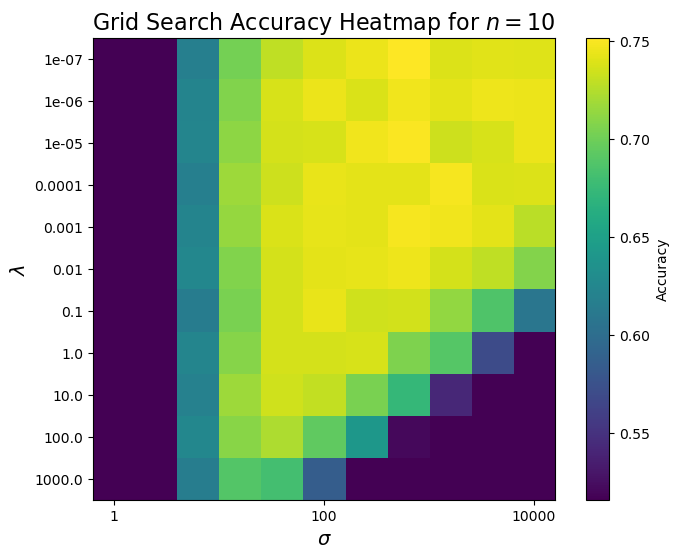

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# Define hyperparameter grid
# lambdas = [1e-2, 1e-1, 1]
lambdas = np.logspace(-7, 3, num=11)
# sigmas = [0.1, 1, 10]
sigmas = np.logspace(0, 4, num=11)
num_features = 10

best_accuracy = 0
best_params = None

# Store results for plotting
repetition = 100
grid_results = np.zeros((repetition, lambdas.shape[0], sigmas.shape[0]))
print(grid_results.shape)

for r in tqdm(range(repetition)):
    for l,lam in enumerate(lambdas):
        for s,sigma in enumerate(sigmas):
            # Train and evaluate KRR with RFF
            preds = KRR_with_RFF(X_train, y_train, X_test, lam, sigma, num_features=num_features)
            accuracy = accuracy_score(y_test, preds)
            
            # print(f"Lambda: {lam}, Sigma: {sigma}, Accuracy: {accuracy}")
            
            # Append results for visualization
            # grid_results.append((lam, sigma, accuracy))
            grid_results[r,l,s] = accuracy
            
    # reshuffle dataset 
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels)

# average over repetitions to calculate the mean accuarcy
mean_accuracy = np.mean(grid_results, axis=0)
max_acc = 0

for l in range(len(lambdas)):
    for s in range(len(sigmas)):
        if mean_accuracy[l,s] > max_acc:
            max_acc = mean_accuracy[l,s] 
            best_lambda = l
            best_sigma = s

print(f"best_lambda:{best_lambda}\nbest_sigma:{best_sigma}\nbest_acc:{max_acc}")

# print(f"Best Parameters: {best_params}, Best Accuracy: {best_accuracy}")

# # Convert grid results to a structured array for easy plotting
# results_array = np.array(grid_results)
# lambdas_unique = np.unique(results_array[:, 0])
# sigmas_unique = np.unique(results_array[:, 1])

# # Create accuracy matrix for heatmap
# accuracy_matrix = np.zeros((len(lambdas_unique), len(sigmas_unique)))
# for i, lam in enumerate(lambdas_unique):
#     for j, sigma in enumerate(sigmas_unique):
#         match = results_array[(results_array[:, 0] == lam) & (results_array[:, 1] == sigma)]
#         if len(match) > 0:
#             accuracy_matrix[i, j] = match[0, 2]

# # Plotting as a heatmap

# Use LateX for text rendering
plt.rc('text', usetex=False) # usetex = True
plt.figure(figsize=(8, 6))
plt.imshow(mean_accuracy, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Accuracy")
# plt.xticks(range(len(sigmas_unique)), sigmas_unique, rotation=45)
# Only show 1, 100, 10000 for sigma
plt.xticks([0, 5, 10], [1, 100, 10000])
plt.yticks(range(len(lambdas)), lambdas)
plt.xlabel("$\sigma$", fontsize=14)
plt.ylabel("$\lambda$", fontsize=14)
plt.title(f"Grid Search Accuracy Heatmap for $n = {num_features}$", fontsize=16)
plt.savefig("grid_search_heatmap.pdf")
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

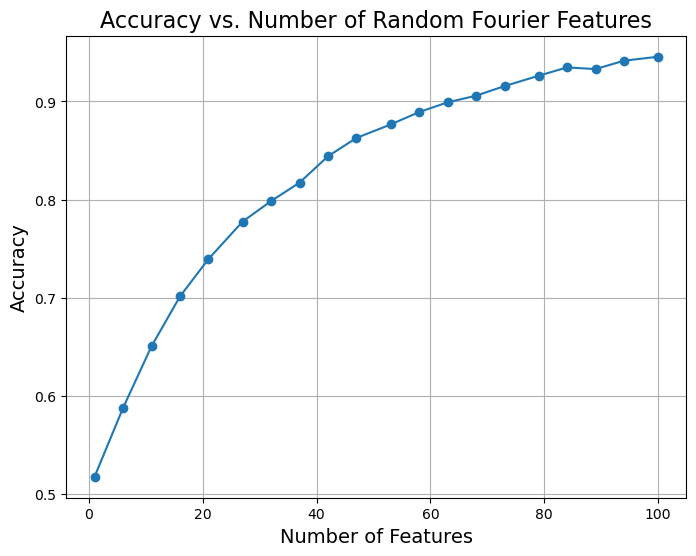

In [9]:
# Pick the best parameters
# best_lambda = best_params['lambda']
# best_sigma = best_params['sigma']


# Train and evaluate  and plot for different number of features
num_features_list = np.linspace(1, 100, num=20, dtype=int)
accuracies = np.zeros((repetition, num_features_list.shape[0]))
repetition = 100
for r in tqdm(range(repetition)):
    for n,num_features in enumerate(num_features_list):
        preds = KRR_with_RFF(X_train, y_train, X_test, best_lambda, best_sigma, num_features=num_features)
        accuracy = accuracy_score(y_test, preds)
        accuracies[r,n] = accuracy
        # print(f"Number of Features: {num_features}, Accuracy: {accuracy}")
    # reshuffle dataset 
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels)
    
mean_accuracy = accuracies.mean(axis=0)        

# Plot the results
plt.rc('text', usetex=False) #usetex=True
plt.figure(figsize=(8, 6))
plt.plot(num_features_list, mean_accuracy, marker='o')
# plt.xscale('log')
plt.xlabel("Number of Features", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs. Number of Random Fourier Features", fontsize=16)
plt.grid(True)
plt.savefig('accuracy_vs_num_features.png')
plt.show()



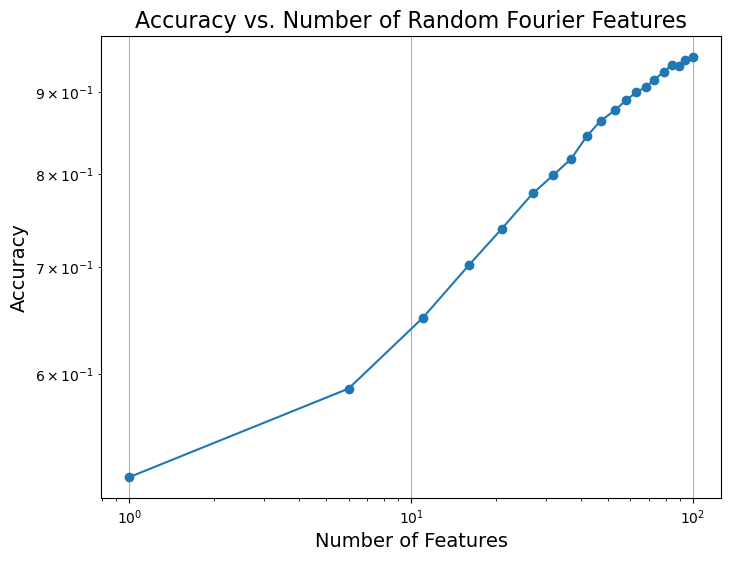

In [10]:
# Plot the results
plt.rc('text', usetex=False) #usetex=True
plt.figure(figsize=(8, 6))
plt.loglog(num_features_list, mean_accuracy, marker='o')
# plt.xscale('log')
plt.xlabel("Number of Features", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs. Number of Random Fourier Features", fontsize=16)
plt.grid(True)
plt.savefig('accuracy_vs_num_features_loglog.png')
plt.show()


In [ ]:
X_train.shape, X_test.shape

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/hf/xpg67mrx1vjb7hzv3ym5m07c0000gn/T/ipykernel_58214/2051215337.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/hf/xpg67mrx1vjb7hzv3ym5m07c0000gn/T/ipykernel_58214/2051215337.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/hf/xpg67mrx1vjb7hzv3ym5m07c0000gn/T/ipykernel_58214/2051215337.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/hf/xpg67mrx1vjb7hzv3ym5m07c0000gn/T/ipykernel_58214/2051215337.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


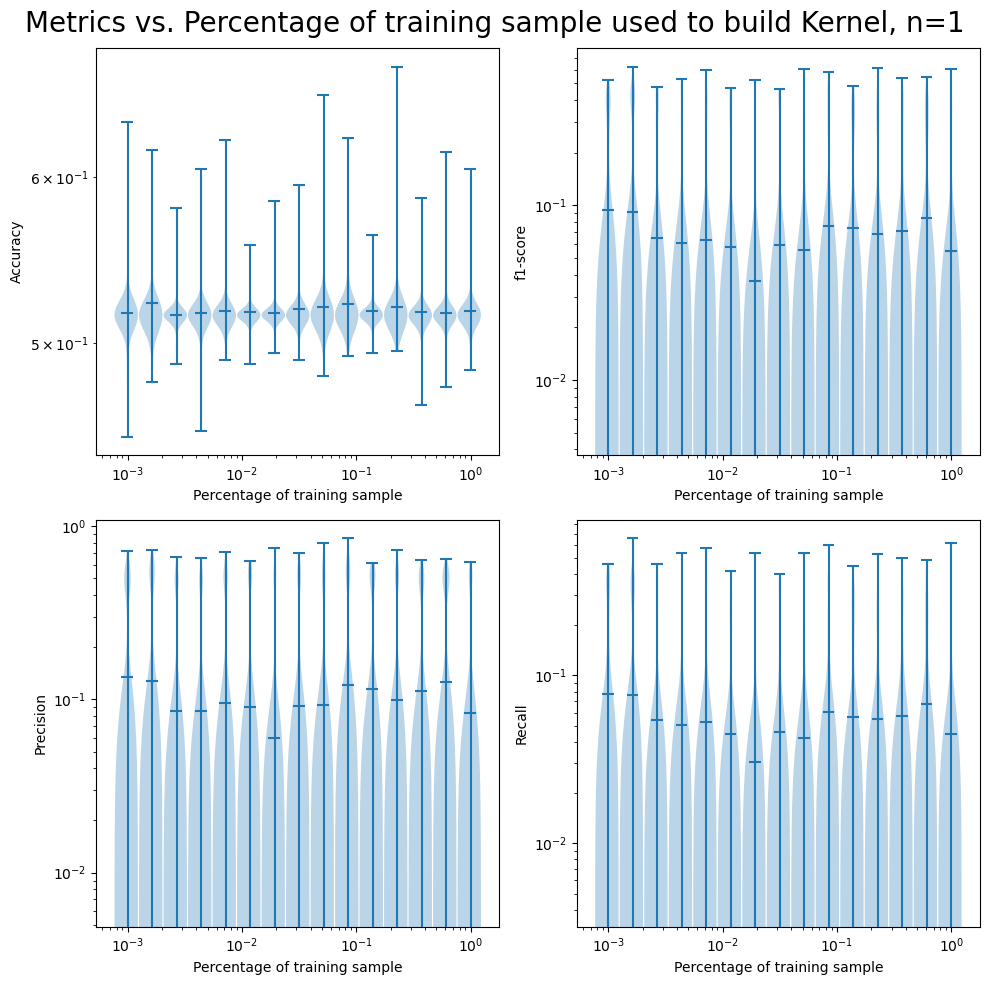

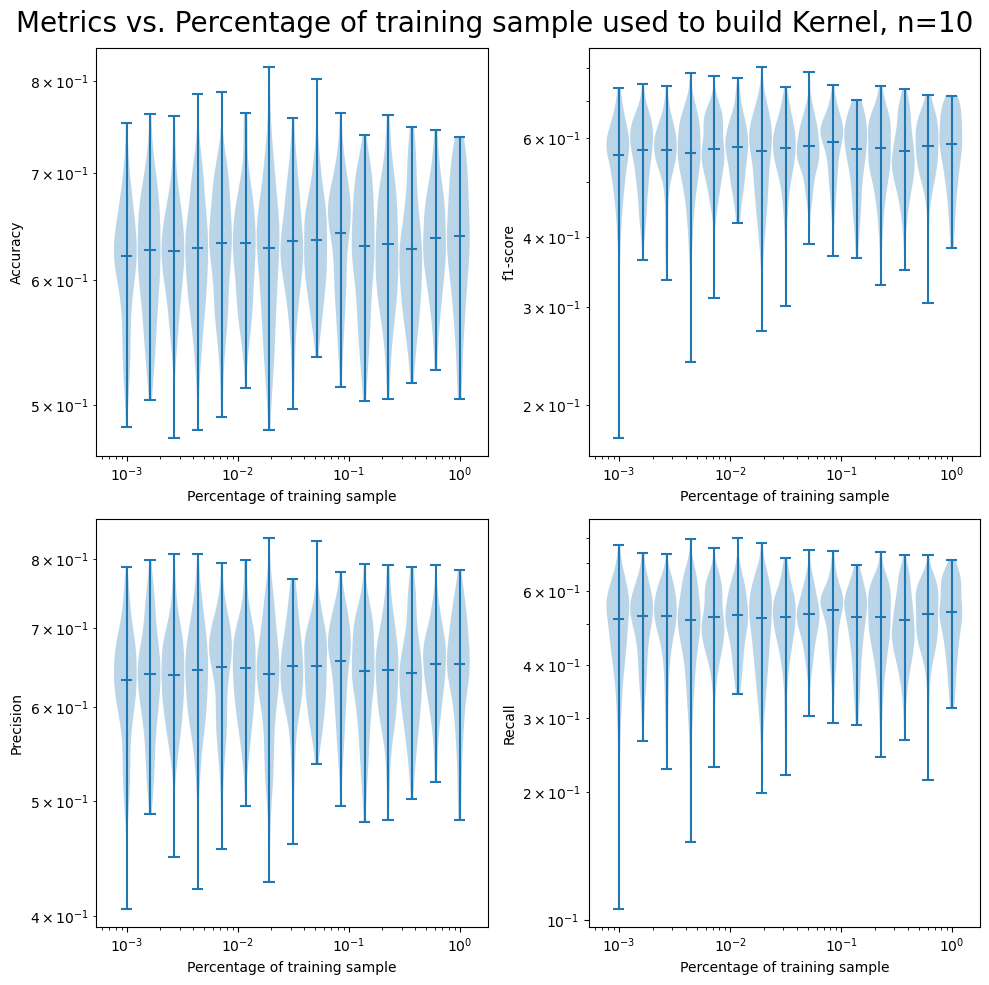

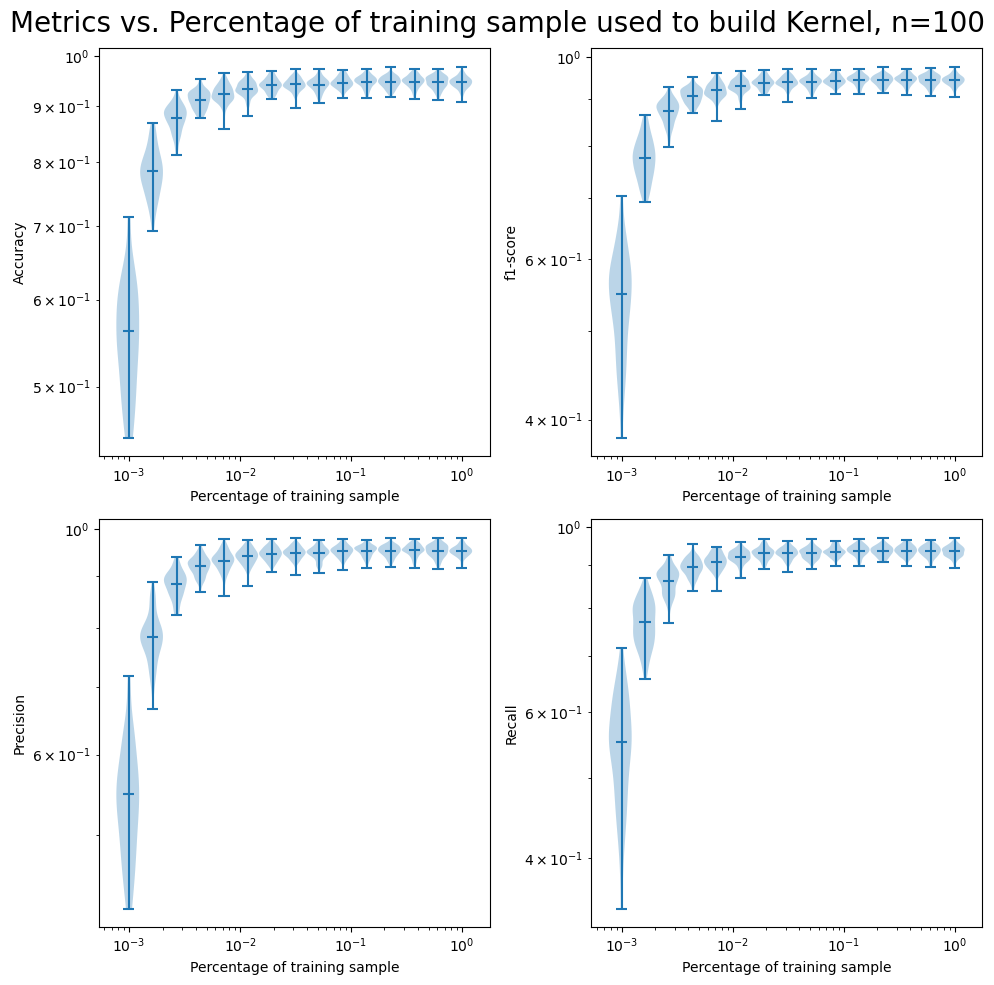

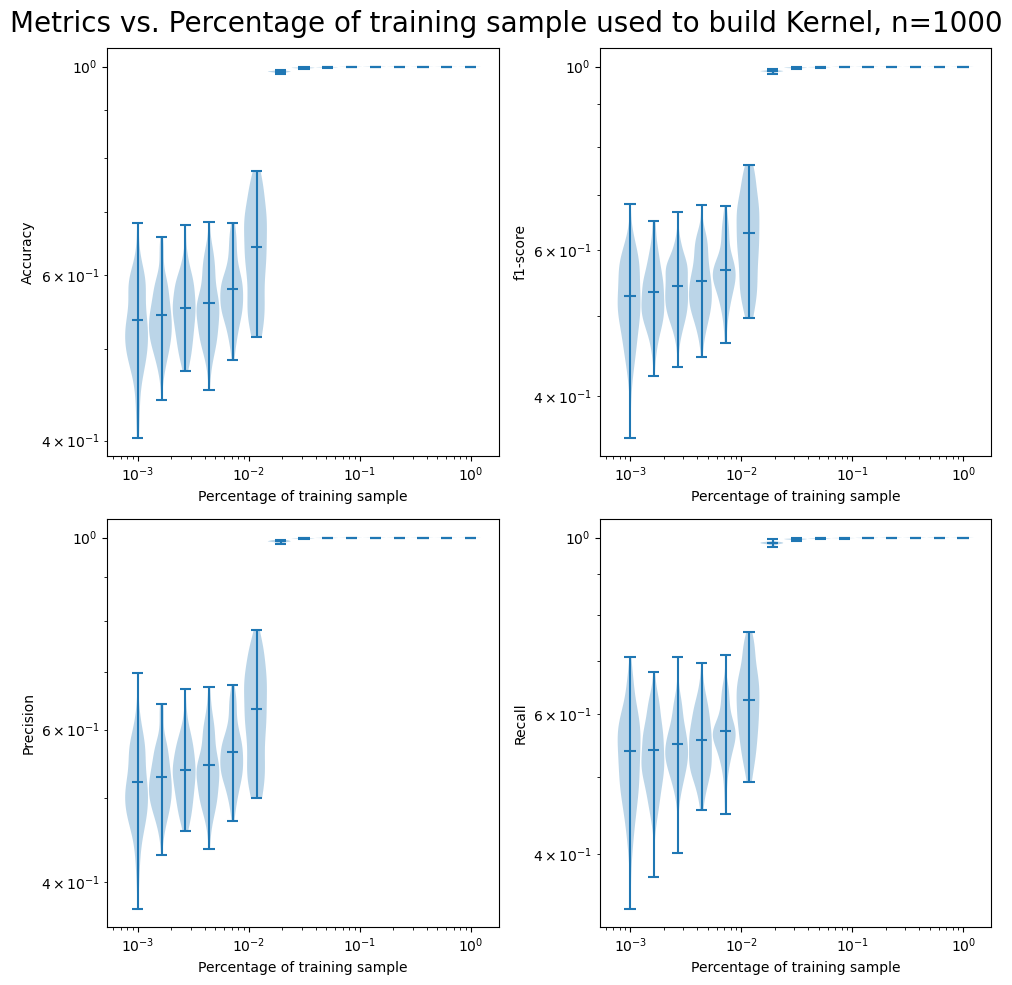

In [11]:
# learning curve for various number of train samples
from math import floor
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)


fraction = np.logspace(-3, 0, num=15, endpoint=True)
num_features= [1, 10, 100, 1000]
repetition = 100

for num_feature in num_features:
    accuracies = np.zeros((repetition,len(fraction)))
    precision = np.zeros((repetition,len(fraction)))
    recall = np.zeros((repetition, len(fraction)))
    f1 = np.zeros((repetition, len(fraction)))
    for r in tqdm(range(repetition)):
        for i,frac in enumerate(fraction):
            N = floor(X_train.shape[0]*frac)
            x_train = X_train[:N,:]
            y_t = y_train[:N]
            preds = KRR_with_RFF(x_train, y_t, X_test, lam= best_lambda, sigma=best_sigma, num_features=num_feature) # best lam and sigma
            accuracies[r,i] = accuracy_score(y_test, preds)
            precision[r,i] = precision_score(y_test, preds)
            recall[r,i] = recall_score(y_test, preds) 
            f1[r,i] = f1_score(y_test, preds)
        # reshuffle dataset 
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels)
        
    accuracies_list = [accuracies[:,i] for i in range(len(fraction))]
    f1_list = [f1[:,i] for i in range(len(fraction))]
    precision_list = [precision[:,i] for i in range(len(fraction))]
    recall_list = [recall[:,i] for i in range(len(fraction))]

    w = 0.2
    width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)

    fig,axs = plt.subplots(2,2, figsize=(10,10), tight_layout=True)
    # fig.tight_layout()
    fig.suptitle("Metrics vs. Percentage of training sample used to build Kernel, n=" + str(num_feature), fontsize=20)
    # plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    axs[0,0].violinplot(dataset=accuracies_list, positions=fraction, showmeans=True, points=repetition, widths=width(fraction,w))
    axs[0,0].set_xscale('log')
    axs[0,0].set_yscale('log')
    axs[0,0].set_xlabel("Percentage of training sample")
    axs[0,0].set_ylabel("Accuracy")
    axs[0,1].violinplot(dataset=f1_list, positions=fraction, showmeans=True, points=repetition, widths=width(fraction,w))
    axs[0,1].set_xscale('log')
    axs[0,1].set_yscale('log')
    axs[0,1].set_xlabel("Percentage of training sample")
    axs[0,1].set_ylabel("f1-score") 
    axs[1,0].violinplot(dataset=precision_list, positions=fraction, showmeans=True, points=repetition, widths=width(fraction,w))
    axs[1,0].set_xscale('log')
    axs[1,0].set_yscale('log')
    axs[1,0].set_xlabel("Percentage of training sample")
    axs[1,0].set_ylabel("Precision")
    axs[1,1].violinplot(dataset=recall_list, positions=fraction, showmeans=True, points=repetition, widths=width(fraction,w))
    axs[1,1].set_xscale('log')
    axs[1,1].set_yscale('log')
    axs[1,1].set_xlabel("Percentage of training sample")
    axs[1,1].set_ylabel("Recall")
    fig.show()
    fig.savefig("training_size_sweep_n" + str(num_feature)+".png")
